In [841]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import multinomial, multivariate_normal

# Introduction
This notebook contains code for a gaussian markov model which trains using expectation maximization. There is, of course, a sklearn implementation of this algorithm. I coded this as a quick exercise.

# Expectation Maximization
Suppose you want to model some distribution $P(x^{(i)}, z^{(i)})$, where the $x^{(i)}$ are observed but the $z^{(i)}$ are not. Then you cannot directly perform maximum likelihood distribution to fit $P(x^{(i)}, z^{(i)})$. The expectation maximization algorithm (EM) is a way to resolve this problem. The following is a conceptual explanation of EM. The algorithm consists of an E-step and an M-step.

We have some log likelihood $l(\theta)$ for parameters $\theta$. This is a strictly concave function - its derivative is always negative.

**E-Step**:
Consider some set of parameters $\theta_1$. A curve is constructed such that it is less than $l(\theta)$ for all values of $\theta$, except $\theta_1$, at which point the curve and $l(\theta)$ have the same value.

**M-Step**:
The maximum of the curve in the E-step is found. The value of $\theta$ at which the curve has its maximum is $\theta_2$.


Because the curve in the E-step is a lower bound on $l(\theta)$, the algorithm increases the likelihood. A caveat is that the algorithm may converge in a local maximum rather than to a global maximum.


## Jensen's Inequality

Jensen's Inequality is crucial to the derivation of expectation maximization. It is what allows us to construct aa curve that is a lower bound on $l(\theta)$ and what allows us to find a point where $l(\theta)$ intersects with the curve in the E-step. It is defined as follows for a concave function:

$$  f(\mathbb{E}[x]) \geq \mathbb{E}[f(x)]$$

In words, the function of the expectation of x is always greater than or equal to the expectation off the same function of x.

Additionally, for a strictly concave function:

$$f(\mathbb{E}[x]) = \mathbb{E}[f(x)] \iff \text{x is constant}$$

## Derivation

Suppose we have m datapoints. We want to maximize $l(\theta)$, which we can write as:

$$\underset{\theta}{\mathrm{argmax}} \text{ } l(\theta) = \underset{\theta}{\mathrm{argmax}} \sum_{i=1}^{m} log(\sum_{z^{(i)}}P(x^{(i)}, z^{(i)})) 
= \underset{\theta}{\mathrm{argmax}} \sum_{i=1}^{m} log(\sum_{z^{(i)}}Q(z^{(i)})[\frac{P(x^{(i)}, z^{(i)})}{Q(z^{(i)})}])$$


The term $Q(z^{(i)})$ is a probability distribution, thus $\sum Q(z^{(i)}) = 1$.

Note we can write the log likelihood $l(\theta)$ as an expectation.

$$l(\theta) = \sum_{i=1}^{m} log (\mathbb{E}_{z^{i} \sim Q_i}[\frac{P(x^{(i)}, z^{(i)})}{Q(z^{(i)})}])$$

We can then use this to invoke Jensen's equality where $f(x) = log(x)$:

$$\sum_{i=1}^{m} log (\mathbb{E}_{z^{i} \sim Q_i}[\frac{P(x^{(i)}, z^{(i)})}{Q(z^{(i)})}])
\geq
\sum_{i=1}^{m} \mathbb{E}_{z^{i} \sim Q_i}[log (\frac{P(x^{(i)}, z^{(i)})}{Q(z^{(i)})}])$$

We can then figure out how to calculate a lower bound curve on the likelihood as a function of theta. Specifically, it is the right hand side of the inequality. Expanding the inequality again, this becomes.

$$\sum_{i=1}^{m}\sum_{z^{(i)}} Q(z^{(i)}) log (\frac{P(x^{(i)}, z^{(i)})}{Q(z^{(i)})})$$

Additionally, Jensen's inequality also tells us this will be equal to $l(\theta)$ where:
$$\frac{P(x^{(i)}, z^{(i)})}{Q(z^{(i)})} = \text{constant}$$

In combination with $Q_i(z^{(i)})$ being a probability distribution, this gives the equation

$$Q_i(z^{(i)}) = P(z^{(i)} | x^{(i)}, \theta)$$

This equation is used in the M-step, and it is essentially the probability that a certain datapoint takes on a certain value of the latent variable for some set of parameters.

## Algorithm
Below is the technical explanation of EM.

**E-Step**
Find the lower bound curve. This simply consists of calculating $Q_i(z^{(i)}) = P(z^{(i)} | x^{(i)}, \theta)$.

**M-Step**
Maximum the lower bound.

$$\theta = \underset{\theta}{\mathrm{argmax}} \sum_{i=1}^{m}\sum_{z^{(i)}} Q(z^{(i)}) log (\frac{P(x^{(i)}, z^{(i)}, \theta)}{Q(z^{(i)})})$$

## Gaussian Mixture Models
Gaussian mixture models are a specific case of EM. Suppose you have m data points $x^{i}$. You want to model this as a mixture of K Gaussian distributions. However, you do not know to which set each $x^{i}$ belongs. Each datapoint thus has some latent variable $z^{i}$ where $z \in \{1, ... , k\}$. We can write the setting of the problem as follows:

$$P(x^{(i)}, z^{(i)}) = P(x^{(i)}|z^{(i)})P(z^{(i)})$$

where
$$z^{(i)} \sim \text{Multinomial}(\phi)$$
$$x^{(i)}|z^{(i)}=j \sim \mathcal{N}(\mu_j, \Sigma_j)$$

Note that by convention, "multinomial distribution" refers to a multinomial distribution with $n=1$ trial.

**E-step**

For Gaussian mixture models, we have a somewhat unique convention, but the similarity to the convention above is obvious. We define:

$$w^{(i)}_j = P(z^{(i)}=j | x^{(i)}, \phi, \mu, \sigma)$$

We can then expand this:

$$w^{(i)}_j = \frac{P(x^{(i)}|z^{(i)}=j)P(z^{(i)}=j)}{\sum_{l=1}^k P(x^{(i)}|z^{(i)}=l)P(z^{(i)}=l)}$$

All of the terms in $w^{(i)}_j$ can be computed from the distributions above. Conceptually, each $w^{(i)}_j$ is the probability that each $x^{(i)}$ belongs to Gaussian $j$.

**M-Step**

The $w^{(i)}_j$ are used to update parameter estimates for the various Gaussians and the multinomial distribution.

$$\phi_j = \frac{1}{M} \sum_{i=1}^{m} w^{(i)}_j$$

$$\mu_j = \frac{\sum_{i=1}^{m} x^{(i)}_j w^{(i)}_j}{\sum_i w^{(i)}_j}$$

$$\Sigma_j = \frac{\sum_{i=1}^{m} (x^{(i)}_j - \mu_j)(x^{(i)}_j - \mu_j)^T}{\sum_i w^{(i)}_j}$$


The process then repeat until convergence. The estimates are used to compute new $w^{(i)}_j$, which are used to compute new parameter estimates and so on.

# Data Generation
To test the model, I create a toy dataset consisting of datapoints drawn from 2 gaussians.

<AxesSubplot:>

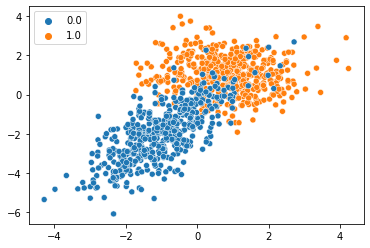

In [842]:
# First Gaussian
mu_1 = [1,1]
sigma_1 = np.asarray([[1,0],[0,1]])
x_1 = np.random.multivariate_normal(mu_1, sigma_1, 500)
y_1 = np.ones_like(x_1[:,1])

# Second Gaussian
mu_2 = [-1,-2]
sigma_2 = np.asarray([[1,1],[1,2]])
x_2 = np.random.multivariate_normal(mu_2, sigma_2, 500)
y_2 = np.zeros_like(x_2[:,1])

x = np.vstack([x_1, x_2])
y = np.hstack([y_1, y_2])

sns.scatterplot(x=x[:,0], y=x[:,1], hue=y)

## Initialization Code
This code is probably unnecessary. It draws latent variables from a multinomial distribution, then uses those latent variables to calculate the first set of parameters for the normal and multinomial distributions.

In [843]:
def init_z(n, k):
    '''
    Initializes distributions for first E-step. z are drawn from multinomial with equal probability of each event.
    n samples
    k classes
    '''
    p_vals = [1/k for i in range(k-1)]
    p_vals.append(1-np.sum(p_vals))
    z = np.random.multinomial(n=1, pvals=[1/k]*k, size=n)
    z = np.argmax(z, axis=1)
    return z

def make_identity_array(z, j, data_dim):
    '''
    Useful for computing identity function. For array 0, return array taking value 1 if z_i == j, 0 otherwise
    '''
    identity_array = np.where(z == j, 1, 0)
    identity_array = np.stack([identity_array for i in range(data_dim)], axis=-1)
    return identity_array

def init_phi(identity_array):
    M = identity_array.shape[0]
    phi = (1/M)*np.sum(identity_array[:,0])
    return phi

def init_mu(x, identity_array):
    # Sum terms where the identify function is 1  
    mu = np.where(identity_array==1, x, 0)
    mu = np.sum(mu)
    mu /= np.sum(identity_array, axis=0)
    return mu

def init_sigma(x, identity_array):
    # Sum terms where the identify function is 1
    sigma = np.where(identity_array==1, x, 0)
    sigma -= x
    data_dim = x.shape[-1]
    sigma = sigma.reshape(-1, 1, data_dim) # (num_samples, 1,  data_dim)
    sigma = np.multiply(sigma.reshape(-1, 2, 1), sigma) # (num_samples, data_dim, data_dim)
    sigma = np.sum(sigma, axis=0)
    sigma /= np.sum(identity_array) # (data_dim, data_dim)
    return sigma

def init_params(x, k): # for data x and k gaussians
    num_samples = x.shape[0]
    data_dim = x.shape[-1]
    
    z = init_z(num_samples, k)
    phis = np.zeros(k)
    sigmas = np.zeros((k, data_dim, data_dim))
    mus = np.zeros((k, 1, data_dim))
    
    for i in range(k):
        identity_array = make_identity_array(z, i, data_dim)
        phis[i] = init_phi(identity_array)
        sigmas[i] = init_sigma(x, identity_array)
        mus[i] = init_mu(x, identity_array)
        
    return phis, sigmas, np.squeeze(mus)

# E-Step Code

Code to compute $w^{(i)}_j$ for some known $\phi, \Sigma, \mu$. The variable $w^{(i)}_j$ gives the probability that datapoint i belongs to Gaussian j.

In [844]:
def multinomial_pdf(phis, j):
    '''
    Assuming 1 trial, i.e. categorical distribution
    '''
    return phis[j]

def gaussian_pdf(x, mu, sigma):
    mvn = multivariate_normal(mean=mu, cov=sigma)
    return mvn.pdf(x)

def e_step(x, mus, sigmas, phis, k):
    data_dim = x.shape[0]
    probs = np.zeros((data_dim, k))
    for i, mu in enumerate(mus):
        prob_x_given_z = gaussian_pdf(x, mu, sigmas[i])
        prob_z = multinomial_pdf(phis, i)
        probs[:, i] = prob_x_given_z * prob_z
        
    # Normalize
    denominator = np.sum(probs, axis=1)
    denominator = np.stack([denominator for j in range(k)], axis=1)
    
    w = probs /denominator
    
    return w

# M-step
This recomputes new parameters for each distribution using the variable $w$.

In [845]:
def m_step_phi(w):
    phi = np.sum(w, axis=0)
    phi /= w.shape[0]
    return phi

def m_step_mu(x, w, phis):
    n_samples = x.shape[0]
    data_dim = x.shape[1]
    k = w.shape[1]
    mu = np.zeros((k, data_dim))
    for j in range(k):
        mu_j = np.stack([w[:, j] for i in range(data_dim)], axis=-1)*x
        mu_j = np.sum(mu_j, axis=0)
        denominator = phis[j]*n_samples
        mu_j /= denominator
        mu[j] = mu_j
    return mu

def m_step_sigma(x, w, phi, mu):
    n_samples = x.shape[0]
    data_dim = x.shape[1]
    k  = w.shape[1]
    sigma = np.zeros((k, data_dim, data_dim))
    
    for j in range(k):
        diff = x - mu[j]
        w_vec = np.stack([w[:, j] for i in range(data_dim)], axis=-1)
        diff_mult = diff*w_vec
        
        diff_mult = diff_mult[:, np.newaxis, :]
        diff = diff[:, :, np.newaxis]
        numerator = diff*diff_mult
        
        denominator = phi[j]*n_samples
        sigma_j = np.sum(numerator, axis=0)
        sigma_j /= denominator
        
        sigma[j] = sigma_j
        
    return sigma
        

def m_step(x, w, phis, mus):
    phis = m_step_phi(w)
    mus = m_step_mu(x, w, phis)
    sigma = m_step_sigma(x, w, phis, mus)
    
    return mus, phis, sigma

# Combine E-Step and M-Step
The Gaussian mixture model is trained by performing the E-step and M-step iteratively until some convergence condition is met. In this case, I just track improvements in the means of Gaussians, although

In [846]:
def GMM(x, k):
    phis, sigmas, mus = init_params(x, k)
    w_old = e_step(x, mus, sigmas, phis, k)
    shift = 10
    i = 1
    
    while shift > 1e-10:
        mus, phis, sigmas = m_step(x, w_old, phis, mus)
        
        w_new = e_step(x, mus, sigmas, phis, k)
        shift = np.linalg.norm(w_new-w_old)
        w_old = w_new.copy()
        i += 1
        
    print(f'Finished in {i} iterations')
    return w_new, mus, phis, sigmas

w, mus, phis, sigmas = GMM(x, 2)

Finished in 217 iterations


# Results

Visualizations are plotted below. Note that the model has not conceptt of which Gaussian in the mixture is which, just that there are two Gaussians.

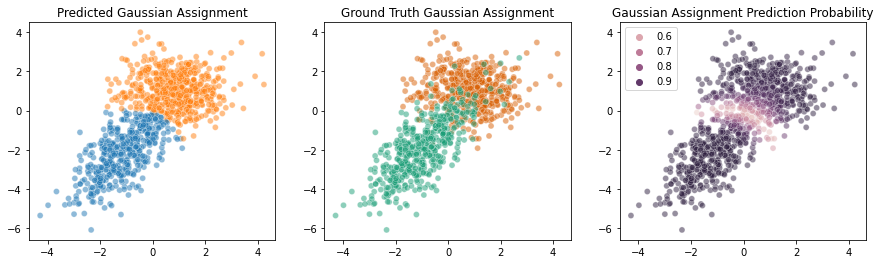

In [847]:
fig, axes = plt.subplots(1,3, figsize=(15,4))
y_hat = np.argmax(w, axis=1)
y_probs = np.max(w, axis=1)

sns.scatterplot(x=x[:,0], y=x[:,1], hue=y_hat, alpha=0.5, ax=axes[0], legend=False)
axes[0].set_title('Predicted Gaussian Assignment')

sns.scatterplot(x=x[:,0], y=x[:,1], hue=y, palette='Dark2', alpha=0.5, ax=axes[1], legend=False)
axes[1].set_title('Ground Truth Gaussian Assignment')

sns.scatterplot(x=x[:,0], y=x[:,1], hue=y_probs, alpha=0.5, ax=axes[2])
axes[2].set_title('Gaussian Assignment Prediction Probability')

plt.show()

We can see from the above that prediction probabilities are low around what looks like a boundary between the two means. This generally corresponds to an area of overlap.

# Computing P(x)
One of the benefits of the GMM is that it can easily be used to compute P(x).

In [848]:
def multinomial_pdf(phis, j):
    '''
    Assuming 1 trial
    '''
    return phis[j]

def gaussian_pdf(x, mu, sigma):
    mvn = multivariate_normal(mean=mu, cov=sigma)
    return mvn.pdf(x)

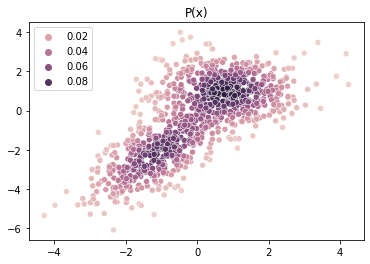

In [849]:
def compute_prob_density(mus, phis, sigmas):
    k = len(phis)
    probs = np.zeros((k, x.shape[0]))
    for i, phi in enumerate(phis):
        prob_x_given_z = gaussian_pdf(x, mus[i], sigmas[i])
        prob_z = phi
        probs[i] = prob_x_given_z * prob_z
        
    probs = np.sum(probs, axis=0)
    
    return probs
    
p_x = compute_prob_density(mus, phis, sigmas)
sns.scatterplot(x=x[:,0], y=x[:,1], hue=p_x)
plt.title('P(x)')
plt.show()

We can see above two areas of higher density. 